In [11]:
from myutils import *
from matplotlib.cm import ScalarMappable
from shapely.geometry import LineString

pf_cmap = plt.get_cmap('viridis')


In [22]:
# Rutas y nombres de archivos
path_source = '../GeoData/'
path_scenario = 'Results/scenario1/'
file_scenario = 'Points_instances.gpkg'
layer_scenario = 'Instance_7'
out = 'Instance_7'

In [23]:
# Resultados de la instancia
with open(path_scenario+out+'_results.pkl', 'rb') as f:  
        pf = pickle.load(f)
        f.close()
pf_obj, pf_var, pf_as = pf


# Datos de la instancia
instance_name = path_scenario + out + '.pkl'
with open(instance_name, 'rb') as f:  
        instance = pickle.load(f)
        f.close()
        
origenes = instance['origenes']
destinos = instance['destinos']
origen_i_to_node = instance['origen_i_to_node']
origen_node_to_i = instance['origen_node_to_i']
destino_i_to_num = instance['destino_i_to_num']
destino_num_to_i = instance['destino_num_to_i']
destino_num_to_node = instance['destino_num_to_node']
destino_node_to_num = instance['destino_node_to_num']
capacidades = instance['capacidades']
demanda = instance['demanda']
matriz_OD = instance['matriz_OD']
rutas = instance['rutas']      

In [24]:
# Carga las capas complementarias
cdmx_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='CDMX', encoding='utf-8')
alcaldias_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='alcaldias', encoding='utf-8')
regiones_layer = gpd.read_file(path_source+'Polygons.gpkg', layer='regiones', encoding='utf-8')

In [25]:

# Carga las pltbs
pltbs = gpd.read_file(path_source + 'PLTBs.gpkg', layer = 'PLTBs_nodes')

# Serializa los datos de tipo lista
pltbs['streets'] = pltbs['streets'].apply(json.loads)
pltbs['streets'] = pltbs['streets'].apply(lambda x: list(set(x)))
pltbs['oneway'] = pltbs['oneway'].apply(json.loads)
pltbs['length'] = pltbs['length'].apply(json.loads)
pltbs['capacity'] = pltbs['capacity'].apply(json.loads)
pltbs['grouped'] = pltbs['grouped'].apply(json.loads)
pltbs_grupos= [item for sublist in [ i for i in pltbs['grouped']] for item in sublist]
pltbs_nodos = list(pltbs['node'])
pltbs.set_index('node', inplace = True)

# Carga los colapsos
colapsos = gpd.read_file(path_scenario+file_scenario, layer = layer_scenario)
colapsos.set_index('num', inplace = True)

nodos = gpd.read_file(path_source + 'graph_transport.gpkg', layer = 'nodes')
nodos.set_index('osmid', inplace = True)
calles = gpd.read_file(path_source + 'graph_transport.gpkg', layer = 'edges')

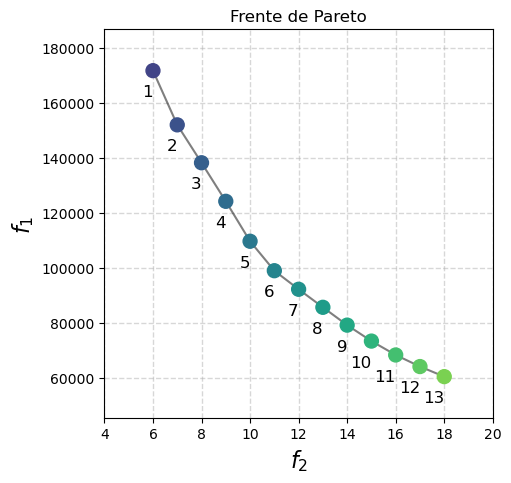

In [26]:
color_in_cmap = [pf_cmap((i/(len(pf_obj)-1))*(0.8-0.2) + 0.2) for i in range(len(pf_obj)) ]

fig,ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)

ax.plot(pf_obj[:,1], pf_obj[:,0], c='k', alpha=0.5)
ax.scatter(pf_obj[:,1], pf_obj[:,0], s=100,
           c=color_in_cmap, zorder=3)


ax.set_box_aspect(1)
ax.set_xlabel('$f_2$',fontsize=16)
ax.set_ylabel('$f_1$',fontsize=16)
ax.set_title('Frente de Pareto')
ax.set_xlim([min(pf_obj[:,1])-2,max(pf_obj[:,1])+2])
ax.set_ylim([min(pf_obj[:,0])-15000,max(pf_obj[:,0])+15000])
ax.grid(True, alpha=0.5, linestyle='--', linewidth=1, zorder=0)

for i in range(len(pf_obj)):
    ax.annotate(str(i+1), (pf_obj[i,1], pf_obj[i,0]-5000), fontsize=12, zorder=4, va='top', ha='right')

fig.savefig(path_scenario+out+'_PF.png', dpi=300, bbox_inches='tight')



In [27]:

bases_cmap = plt.get_cmap('gist_rainbow')
# Identifica todas las bases usadas en las soluciones del frente de Pareto

all_bases = set()
for asignacion in pf_as:
    for b in asignacion:
        all_bases.add(b)

all_bases = list(all_bases)

np.random.seed(788284517)
np.random.shuffle(all_bases)

num_colors = max([len(i) for i in pf_obj])
colors_ind = bases_cmap([0.9*i/len(all_bases) for i in range(len(all_bases))])
map_all_colors = {all_bases[i]: tuple(c) for i,c in enumerate(colors_ind)}

pltbs['color_grupo'] = pltbs.index.map(map_all_colors)

In [29]:
vis_preview = True
save_preview = True

reps = [0,len(pf_obj)//2, len(pf_obj)-1]
#reps = [i for i in range(len(pf_obj))]
reps = [0]
for ind_sol in reps:
    ar = pf_as[ind_sol]

    bases, counts = np.unique(ar, return_counts=True)
    grupos = {origen_i_to_node[base]:i for i,base in enumerate(bases)}
    
    num_to_grupo = dict()
    for i,j in enumerate(ar):
        num_to_grupo[destino_i_to_num[i]] = grupos[origen_i_to_node[j]]
        
        
    
    destinos = [destino_i_to_num[i] for i in range(len(ar))]
    gdf_destinos = colapsos.loc[destinos]
    gdf_destinos['grupo'] = gdf_destinos.apply(lambda x: num_to_grupo[x.name], axis = 1)
    gdf_destinos['color_grupo'] = gdf_destinos['grupo'].map({i:base for i,base in enumerate(bases)})
    gdf_destinos['color_grupo'] = gdf_destinos['color_grupo'].map(map_all_colors)
    
    demanda_dict = dict([(i, int(demanda[i])) for i in range(len(ar))])
    gdf_destinos['demanda'] = gdf_destinos.index.map(demanda_dict)
    
    
    
    bases = [origen_i_to_node[i] for i in bases]
    gdf_bases = pltbs.loc[bases]

    
        
    
    gdf_bases['grupo'] = gdf_bases.index.map(grupos)
    gdf_bases['Asignados'] = gdf_bases.index.map({b:c for b,c in zip(bases,counts)})

    gdf_rutas = dict()
    gdf_lineas = dict()


    for j,i in enumerate(ar):
        node_base = origen_i_to_node[i]
        num_destino = destino_i_to_num[j]
        
        # Encuentra la ruta más corta de las dos posibles
        # (Solo hace falta recuperarla, no calcularla)
        node_destino = destino_num_to_node[num_destino][0]
        df_ruta = rutas.get(node_destino, None)
        dist_ruta, ruta = get_route_from_df(df_ruta,node_base)
        
        node_destino2 = destino_num_to_node[num_destino][1]
        df_ruta2 = rutas.get(node_destino, None)
        dist_ruta2, ruta2 = get_route_from_df(df_ruta,node_base)
        
        if dist_ruta2 < dist_ruta:
            dist_ruta = dist_ruta2
            ruta = ruta2
            node_destino = node_destino2
            df_ruta = df_ruta2
            
        
        ruta = [node_destino] + ruta
        ruta_coords = [nodos.loc[i].geometry.coords[0] for i in ruta]
        
        
        
        if ar.tolist().count(i) == 1:
            node_base_real = node_destino
            ruta_geom = LineString([nodos.loc[node_base_real].geometry.coords[0]]*2)
            linea_geom = LineString([nodos.loc[node_base_real].geometry.coords[0]]*2)
            gdf_bases.loc[node_base,'geometry'] =  Point(nodos.loc[node_base_real].geometry.coords[0])
            
        else:
            node_base_real = node_base
            ruta_geom = LineString(ruta_coords)
            linea_geom = LineString([nodos.loc[node_base].geometry.coords[0], 
                                colapsos.loc[num_destino].geometry.coords[0]])
        
        ruta_info = {'geometry':ruta_geom,
                    'distancia':dist_ruta,
                    'base': node_base,
                    'destino': num_destino,
                    'grupo': grupos[node_base],
                    'color_grupo': map_all_colors[i]}
        
        gdf_rutas[num_destino] = ruta_info
        
        lineas_info = {'geometry':linea_geom,
                       'distancia':dist_ruta,
                       'base': node_base,
                       'destino': num_destino,
                       'grupo': grupos[node_base],
                       'color_grupo': map_all_colors[i]}
        
        gdf_lineas[num_destino] = lineas_info

    gdf_rutas = pd.DataFrame.from_records([i for i in gdf_rutas.values()],index='base')
    gdf_rutas = gpd.GeoDataFrame(gdf_rutas, crs="EPSG:6369", geometry = 'geometry')
    
    gdf_lineas = pd.DataFrame.from_records([i for i in gdf_lineas.values()],index='base')
    gdf_lineas = gpd.GeoDataFrame(gdf_lineas, crs="EPSG:6369", geometry = 'geometry')
    
    
    
    
    
    
    
    
    if vis_preview:
        extra = 0.05
        xmin, ymin, xmax, ymax = gdf_destinos.total_bounds
        xmin, ymin, xmax, ymax = xmin-extra*(xmax-xmin), ymin-extra*(ymax-ymin), xmax+extra*(xmax-xmin), ymax+extra*(ymax-ymin)

        fig, ax = plt.subplots(dpi=600,figsize=(5,5), constrained_layout=True)



        # --------- Polígonos ----------------
        # ------------------------------------
        cdmx_layer.plot(color='none', edgecolor='k', alpha=1, zorder=0, ax =ax, lw=1)
        alcaldias_layer.plot(color='none', edgecolor=(0,0,0,0.5), zorder=0, ax =ax,ls='--', lw=0.5)
        #regiones_layer.plot(column='region', zorder=0, ax =ax, lw=1, facecolor='none',cmap='viridis')



        # --------- Grafos ---------------
        # --------------------------------
        calles.plot(ax = ax, zorder=5, color = 'k', alpha=1, lw=0.01)



        # --------- Rutas ----------------
        # --------------------------------
        colors = gdf_lineas['color_grupo'].tolist()
        gdf_lineas.plot(ax = ax, zorder=1,lw=1.2, color='k', alpha=0.5)    
        gdf_lineas.plot(ax = ax, zorder=1,lw=0.8, label='Asignaciones', color=colors)    
        
        

        # -------- Destinos --------------
        # --------------------------------
        gdf_destinos.plot(ax = ax, zorder=5, color='k', markersize=34, marker='o', alpha=0.5)
        colors = gdf_destinos['color_grupo'].tolist()
        gdf_destinos.plot(ax = ax, zorder=6, markersize=20, marker='o', alpha=1, label='Colapsos',color=colors)


        # --------- Bases ----------------
        # --------------------------------
        gdf_bases[gdf_bases['Asignados']==1].plot(ax = ax, zorder=1, markersize=400, marker='o',
                                                facecolor=(0,0,0,0),edgecolor='k', lw=1, label='Bases aisladas')
        #gdf_bases[gdf_bases['Asignados']>1].plot(ax = ax, zorder=8, column='grupo', markersize=50, marker='s', alpha=1, cmap='Set2')
        gdf_bases[gdf_bases['Asignados']>1].plot(ax = ax, zorder=9, markersize=30, marker='s', facecolor=(0,0,0,0), color = 'k', label='Bases')
        
        # Agregar etiquetas de número de bases asignadas
        for idx, row in gdf_bases[gdf_bases['Asignados']>1].iterrows():
            ax.annotate(text='\n'+str(row['Asignados'])+' ', xy=(row.geometry.x, row.geometry.y), ha='right', va='center',zorder=10, fontsize=11)


        

        ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncols=4, frameon=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Solución '+str(ind_sol+1))
        ax.grid(True, alpha=0.5, linestyle='--', linewidth=1, zorder=0)
        
        if save_preview:
            fig.savefig(path_scenario+out+'_sol'+str(ind_sol+1)+'.png', dpi=300, bbox_inches='tight')
            plt.close(fig)
            
            
    